In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from machines import mps_trotter
from machines import mps_utils
import utils

data_dir = "D:/DATA/ClockV2/final_dense"

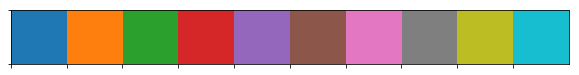

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 20

cp = sns.color_palette()
sns.palplot(cp)
plt.show()

In [3]:
n_sites = 6
h_init = 1.0
h_ev = 0.5

d_bond = 4
time_steps = 60
t = np.linspace(0.0, 5.0, time_steps + 1)
dt = t[1] - t[0]

exact_state, exact_obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
mps = mps_trotter.TFIMTrotterMPS(exact_state[0], d_bond, dt, h=h_ev)
mps_state = mps.evolve(time_steps)

Unitarity tests

In [19]:
ux = mps_utils.mpo_to_dense(mps.x_op[:, np.newaxis, :, :, np.newaxis])
uz = mps_utils.mpo_to_dense(mps.zz_op)

ident = np.eye(ux.shape[0], dtype=ux.dtype)

diff1 = ux.dot(ux.conj().T) - ident
diff2 = ux.conj().T.dot(ux) - ident
print(diff1.mean(), diff1.real.std(), diff1.imag.std())
print(diff2.mean(), diff2.real.std(), diff2.imag.std())
         
diff1 = uz.dot(uz.conj().T) - ident
diff2 = uz.conj().T.dot(uz) - ident
print(diff1.mean(), diff1.real.std(), diff1.imag.std())
print(diff2.mean(), diff2.real.std(), diff2.imag.std())

(-1.5826731210107797e-17+0j) 1.3003219540851472e-16 3.660782718032014e-18
(-1.5826731210107797e-17+0j) 1.3003219540851472e-16 3.660782718032014e-18
(4.336808689942018e-18+0j) 0.32304091043541716 0.07084892508046155
(5.204170427930421e-18+0j) 0.32304091043541716 0.07084892508046155
